# Контест: направление BI (Business Intelligence)

# Школа: AI Masters

# SQL


В таблице находятся данные по платежам клиентов.   
Имеющиеся поля:  
Region - город клиента.   
ItemName - тип товара.    
Medium - канал привлечения.  
ActionDate - дата платежа.  
Qty - кол-во товаров в покупке.  
NetSales - сумма покупки (выручка).  
Profit - чистая прибыль с покупки. 


Необходимо решить следующие задачи (от
Вас ожидается SQL-код с указанием
диалекта):  

2.1 Найти регион с покупкой более чем двумя типами товаров. 

2.2 Найти среднюю стоимость 2х наиболее часто покупаемых типов товаров. 

2.3 Рассчитать среднее время (кол-во дней) между покупками в каждом регионе. 

2.4 Посчитать процент GMV (оборот) кофе japan от всех покупках в каждом регионе за каждый месяц. 

2.5 Отсортировать по дате покупок и для первых 5 строк посчитать скользящее
среднее NetSales c размером окна 3 - т.е. средней из текущей, предыдущей и
следующей строчек.  

2.6 За каждый день вывести канал привлечения с максимальным GMV, и собственно сам GMV этого канала.  

2.7 Найти наименее маржинальный канал привлечения (для которого минимально
отношение прибыли к выручке).

## Решение
В решении используется PostgreSQL.


---


В решении отталкивался от того, что в одной покупке не может быть двух разных товаров.

In [205]:
# 2.1 Найти регион с покупкой более чем двумя типами товаров.

# select region from (SELECT region, count(distinct itemname) cnt FROM payments group by region having count(DISTINCT itemname) > 2) t1;

In [206]:
# 2.2 Найти среднюю стоимость 2х наиболее часто покупаемых типов товаров.

# select avg(netsales) from (select * from (select itemname, count(*) cnt from payments group by itemname) total left join payments t1 on t1.itemname = total.itemname order by cnt desc limit 2) t2 ;

In [207]:
# 2.3 Рассчитать среднее время (кол-во дней) между покупками в каждом регионе.

# select region,  avg(nextdate - actiondate) from (
# select *, lead(actiondate) over(Partition by region order by actiondate) nextdate from payments) t1 group by region;

In [208]:
# 2.4 Посчитать процент GMV (оборот) кофе japan от всех покупках в каждом регионе за каждый месяц.

# select month_id, region, sum(netsales)/(select sum(t1.netsales) from payments t1 where extract(Month from t1.actiondate) = month_id and t1.region = t2.region) gmv
# from generate_series(1, 12) as month_id
# left join payments t2 on month_id = Extract(Month from t2.actiondate)
# and itemname = 'кофе Japan'
# group by region, month_id order by month_id;

In [209]:
# 2.5 Отсортировать по дате покупок и для первых 5 строк посчитать скользящее среднее NetSales c размером окна 3 - т.е. средней из текущей, предыдущей и следующей строчек.

# select region, itemname, medium, actiondate, qty, netsales, profit, average/cnt from ( select *, CASE WHEN lead(netsales) over(order by actiondate) is null or LAG(netsales) over(order by actiondate) is null THEN 2 else 3 END cnt,
#(COALESCE(netsales,0) + COALESCE(lead(netsales) over(order by actiondate),0) + COALESCE(Lag(netsales) over(order by actiondate),0)) average  from (select * from payments order by actiondate limit 5) t1) t2;

In [210]:
# 2.6 За каждый день вывести канал привлечения с максимальным GMV, и собственно сам GMV этого канала.

# SELECT actiondate,medium,gmv FROM (select actiondate, medium,sum(netsales) gmv,max(sum(netsales)) over(partition by actiondate) max_gmv from payments group by actiondate, medium) t1 where gmv = max_gmv;

In [211]:
# 2.7 Найти наименее маржинальный канал привлечения (для которого минимально отношение прибыли к выручке)

# SELECT * from (SELECT medium, sum(profit/netsales) min_marg from payments group by medium) t1 order by min_marg limit 1;

# Чужак в чужой 

Разработайте алгоритм выставления цены, объясните и обоснуйте его работу так, чтобы даже
индийский заказчик не мог придраться, реализуйте алгоритм!

##  Решение
Перед нами стоит задача регрессии. Для начала посмотрим на наши данные и попытаемся визуализировать их.

In [212]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

import matplotlib.pyplot as plt
import seaborn as sns

In [213]:
df = pd.read_csv('input.txt', sep=" ", header=None)

In [214]:
cols = ['Фича 1', 'Фича 2', 'Фича 3', 'Цена']
df.columns = cols
df.head()

,Фича 1,Фича 2,Фича 3,Цена
0,0.78,3.0,0.4,9
1,0.61,7.0,4.5,20
2,0.41,2.8,4.0,10
3,0.08,3.4,3.8,10
4,0.03,1.3,2.2,6


In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Фича 1  20 non-null     float64
 1   Фича 2  20 non-null     float64
 2   Фича 3  20 non-null     float64
 3   Цена    20 non-null     int64  
dtypes: float64(3), int64(1)
memory usage: 768.0 bytes


In [216]:
df.describe()

,Фича 1,Фича 2,Фича 3,Цена
count,20.000000,20.000000,20.000000,20.000000
mean,0.504500,4.405000,3.800000,21.450000
std,0.301339,2.667835,2.095358,24.143159
min,0.030000,0.400000,0.200000,1.000000
25%,0.282500,2.250000,2.100000,8.250000
50%,0.500000,3.700000,4.100000,16.500000
75%,0.682500,7.025000,5.275000,22.000000
max,0.970000,9.000000,7.000000,100.000000


Как видно из предыдущих таблиц, мы работаем с численными признаками.

Посмотрим на распределние целевой переменной.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


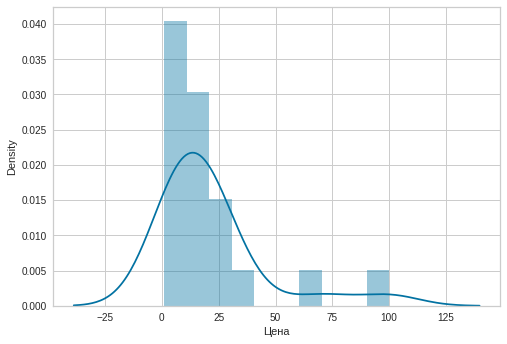

In [217]:
sns.distplot(df['Цена']);

Похоже, что будь у нас больше данных мы бы получили бимодальное распределение. Проверим с помошью IQR данные на наличие выбросов.

In [218]:
def subset_by_iqr(df, column, whisker_width=1.5):

    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    return df.loc[filter], df.loc[~filter]

In [219]:
df, outliers = subset_by_iqr(df, 'Цена', whisker_width=1.5)

In [220]:
outliers

,Фича 1,Фича 2,Фича 3,Цена
5,0.52,8.3,6.2,100
16,0.97,9.0,5.7,70


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


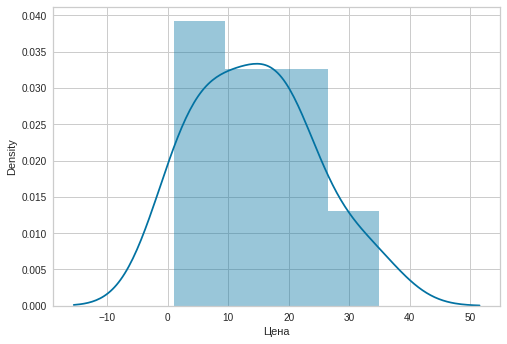

In [221]:
sns.distplot(df['Цена']);

In [222]:
X, y = df.drop('Цена', axis=1), df['Цена']

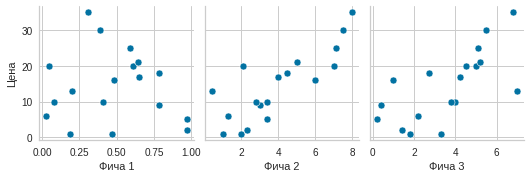

In [223]:
sns.pairplot(data=df, y_vars='Цена', x_vars=X.columns, kind='scatter')
plt.show()

Похоже на некоторую линейную зависимость. Вероятно, для определения цены достаточно использовать линейную регрессию. Проверим следующие 5 предположений для использования данной модели.

### Предположение 1
Линейная связь между функциями и таргетом. 

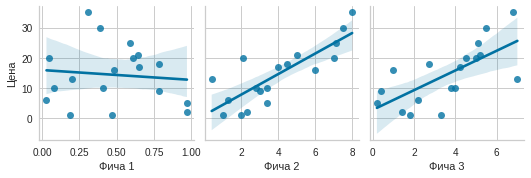

In [224]:
sns.pairplot(data=df, y_vars='Цена', x_vars=X.columns, kind='reg')
plt.show()

Выполняется условие.

### Предположение 2
Незначительная или отсутствующая мультиколлинеарность между признаками. 


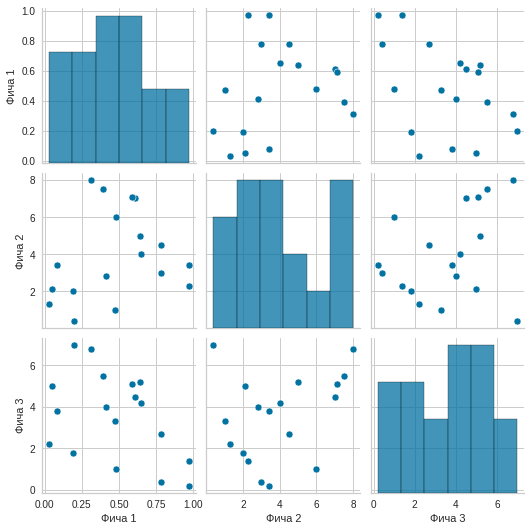

In [225]:
sns.pairplot(X);

Как видно из графиков предположение выполняется. Для пущей уверенности построим матрицу корреляции.

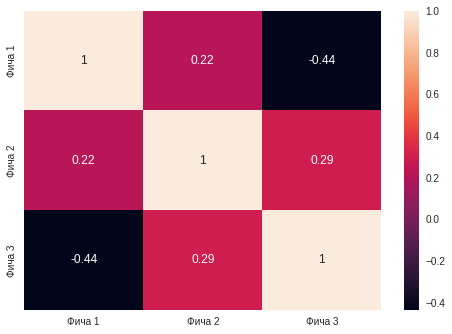

In [226]:
sns.heatmap(X.corr(), annot=True);

Для всех признаков значение корреляции по модулю меньше 0.5, это слабая корреляция.

### Предположение 3
Гомоскедастичность.

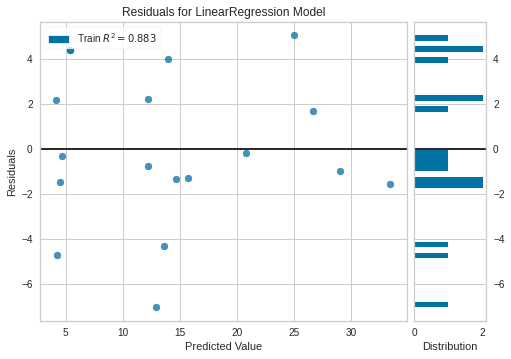

In [227]:
model = linear_model.LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X, y)  

visualizer.show()

Остатки имеют относительную постоянную дисперсию.

### Предположение 4
Нормальное распределение ошибок.

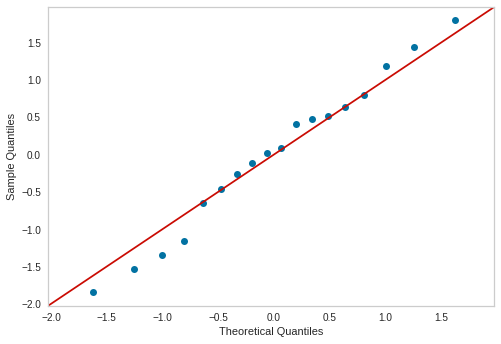

In [228]:
mod_fit = sm.OLS(list(y), X).fit()

res = mod_fit.resid
fig = sm.qqplot(res, fit=True, line='45')
plt.grid()
plt.show()

Значительных отклонений не обнаружено.

### Предположение 5
Небольшая автокорреляция или ее отсутствие в остатках

In [229]:
model = sm.OLS(list(y), X)
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              118.0
Date:                Sun, 31 Jul 2022   Prob (F-statistic):                    1.18e-10
Time:                        19:09:10   Log-Likelihood:                         -48.015
No. Observations:                  18   AIC:                                      102.0
Df Residuals:                      15   BIC:                                      104.7
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


Результат проведения теста Дарбина-Ватсона равен 1.4, таким образом наблюдается небольшая автокорреляция (значения 1.5 < d < 2.5 обычно показывают, что нет автокорреляции).

### Вердикт
Проверка предположений показала (с некоторым допущением) возможность использования линейной регрессии для предсказания цены. 

In [230]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    print('\nR^2: {0}'.format(model.score(features, label)))
    
    return df_results

In [231]:
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, height=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.

R^2: 0.8829130842677858


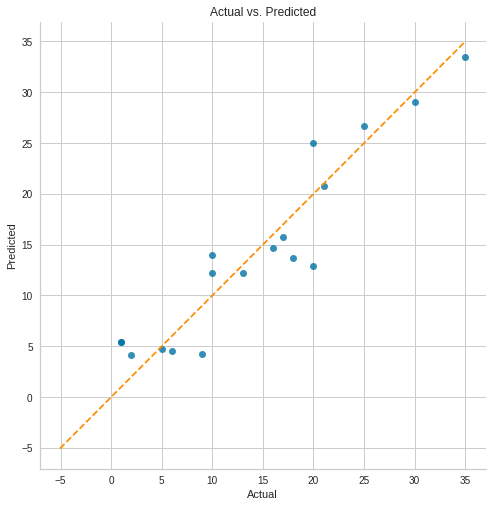

In [232]:
model = linear_model.LinearRegression()
model.fit(X, y)
linear_assumption(model, X, y)

# Дихлофос 2.0
Тестировалась сила воздействия средства на
насекомых при различном уровне концентрации и различной температуре. Всего было
4 варианта концентрации средства и 3 варианта температуры. 


---


Проанализируйте данные и укажите как 
температура и концентрация влияют на эффективность средства и если взаимное влияние этих факторов на эффективность.
Для ответа на этот вопрос сделайте преобразование данных (если требуется),
выпишите статистическую модель и обоснуйте выбор, явно пропишите все
предположения и обоснуйте их, выполните статистический анализ данных в рамках
выбранной модели и сделайте выводы.

## Решение

In [233]:
cols = ['Дозировка','Температура',\
        'Число тараканов в группе тестирования','Число погибших насекомых']

In [234]:
df = pd.read_csv('Дихлофос.txt', sep=" ", header=None)
df.columns = cols
df

,Дозировка,Температура,Число тараканов в группе тестирования,Число погибших насекомых
0,1,20,20,5
1,1,25,20,6
2,1,30,20,8
3,2,20,20,8
4,2,25,20,9
5,2,30,20,12
6,3,20,20,10
7,3,25,20,13
8,3,30,20,13
9,4,20,20,18


In [235]:
X = df[df.columns[:2]]
y = df['Число погибших насекомых']

Эффективность := число погибших насекомых.

Предположение 1: при увеличении дозировки эффективность средства увеличивается (common sense).  

Предположение 2: при увеличении температуры эффективность средства увеличивается (common sense).  

Предположение 3: линейная зависимость между признаками и таргетом (в противном случае будем искать другую зависимость).

Необходимо категориальные данные закодировать. На температуру мы можем смотерть как на категориальный признак (конечное число значений, получаются как бы группы: эксперименты проведённых при t температуре).

In [236]:
onehot_encoder = OneHotEncoder()
encode_data = onehot_encoder.fit_transform(X)

In [241]:
encode_data.toarray()

array([[1., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 1.]])

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.

R^2: 0.9881058578650015


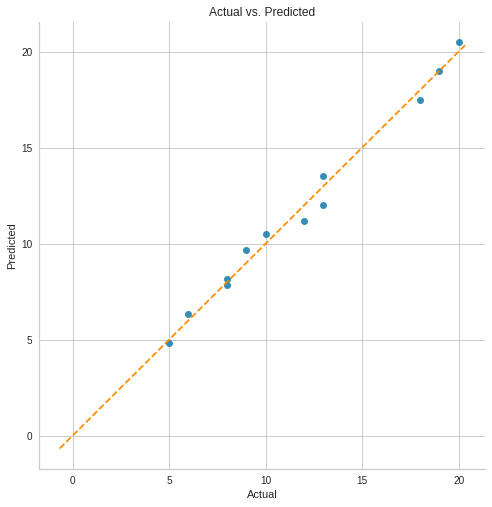

In [237]:
model = linear_model.LinearRegression()
model.fit(encode_data, y)
linear_assumption(model, encode_data, y)

Линейная модель показала высокое качество, R^2: 0.99. Посмотрим на веса модели. 

In [238]:
f_names = onehot_encoder.get_feature_names_out(X.columns)
w = model.coef_
d = dict(zip(f_names, w))

In [239]:
print(*d.items(), sep='\n')

('Дозировка_1', -5.416666666666666)
('Дозировка_2', -2.083333333333333)
('Дозировка_3', 0.2499999999999998)
('Дозировка_4', 7.249999999999999)
('Температура_20', -1.5)
('Температура_25', -7.121104895145041e-17)
('Температура_30', 1.5)


Увеличение температуры и смена дозировки с 1 на 4 спопобствуют увеличению эффективности средства (увеличению количества мертвых насекомых). 

# Ставки на камни
Представьте себе реализацию, в которой спорщик покупает вслепую набор из X
камней, где X выбирается случайно согласно Пуассоновскому распределению с
параметром 80, после чего их вскрывают один за другим. Сразу после вскрытия камня
игрок может выбрать камень своим представителем в споре или отбросить его и начать
вскрывать следующий. Игрок может выбрать только один камень, который будет его
представлять. После того, как камень был выбран, оставшиеся камни из купленного
набора не вскрываются. Вернуться к отвергнутому камню тоже нельзя.






---


Представьте, что Вы играете именно в такую реализацию игры. Опишите и обоснуйте
свою стратегию игры.

## Решение

 1) Для начала разбирёмся с потенциальным числом камней. 

Для Пуассоновского распредления с параметром λ справделиво:

* матожидание = λ
* диспресия = λ

Так же стоит отметить, что по мере увеличения λ Пуассоновское распредление стремиться к нормальному с матожиданием и дисперсией λ. Если λ больше примерно 10, то нормальное распределение является хорошим приближением. Так что можно считать, что при λ = 80 диапазон камней может быть от 53 до 107 (т.е μ ± 3σ, μ = 80, σ ≈ 9).

2)   Определим стратегию.  
Данная задача является вариацией задачи о "разборчивой невесте". Оптимальная стратегия такая: надо отклонить всех первых n/e (где e — основание натурального логарифма) претендентов (~37%) и затем выбрать первого, кто будет лучше всех предыдущих.

3) Определим число камней для отлонения.  
В засивисимости от количества камней в наборе (см. 1 пункт), нужно будет отклонить от 20 до 39 камней и затем выбрать тот, кто будет лучше всех предыдущих.

